# Amortization with Stable Consistency Models

_Author: Valentin Pratz_

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import bayesflow as bf

import keras

from bayesflow.experimental.stable_consistency_model import StableConsistencyModel

This notebook serves as a playground for testing continuous-time consistency models. They are still experimental, as they are not fully tested yet, so please use them at your own discretion and share potential successes/failures. This will help us to judge their usefulness in the context of SBI. Later on, this notebook might evolve into a full tutorial notebook. For now, please refer to the starter notebook if you encounter concepts that are not explained.

In [7]:
simulator = bf.simulators.TwoMoons()

In [8]:
train_data = simulator.sample(2048)
val_data = simulator.sample(512)

In [18]:
adapter = (
    bf.adapters.Adapter()
    .rename("parameters", "inference_variables")
    .rename("observables", "inference_conditions")
)

## sCM Model

In [19]:
inference_network = StableConsistencyModel(
    embedding_kwargs={"embed_dim": 2}
)

### Training

We use the high-level `Workflow` API:

In [20]:
workflow = bf.BasicWorkflow(
    adapter=adapter, 
    simulator=simulator,
    inference_network=inference_network,
)

In [21]:
history = workflow.fit_offline(
    data=train_data, 
    epochs=800,
    batch_size=128,
    validation_data=val_data
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/800
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.1628 - val_loss: 0.1360
Epoch 2/800
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1078 - val_loss: 0.0721
Epoch 3/800
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0303 - val_loss: -0.0053
Epoch 4/800
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.0327 - val_loss: -0.0946
Epoch 5/800
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: -0.1277 - val_loss: -0.1854
Epoch 6/800
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: -0.2059 - val_loss: -0.2780
Epoch 7/800
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: -0.2715 - val_loss: -0.3676
Epoch 8/800
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.3086 - val_loss: -0.3833
Epoch 9/800
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.3417 - val_loss: -0.3920
Epoch 10/800
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: -0.3686 - val_loss: -0.4127
Epoch 11/800
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: -0.3796 - val_loss: -0.4170
Epoch 12/800
16/16 ━━━━━━━━━━━━━━━━

Note that after a certain time, the loss is no longer indicative of training performance.

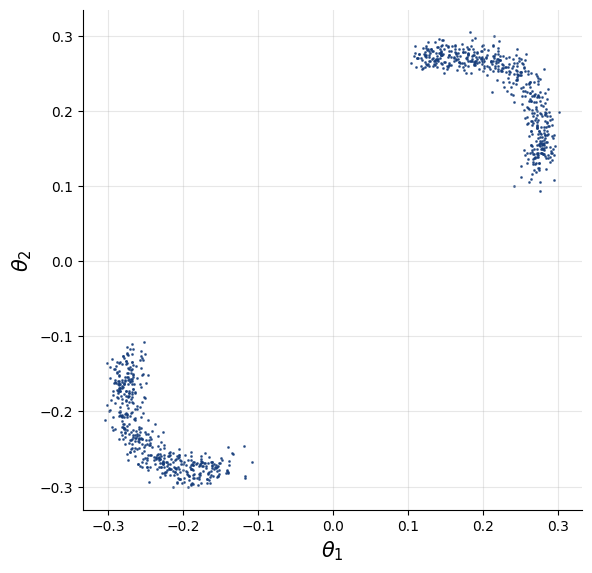

In [23]:
# Set the number of posterior draws you want to get
num_samples = 1000
steps = 30
rho = 3.5

# Obtain samples from amortized posterior
conditions = {"observables": np.array([[0.0, 0.0]]).astype("float32")}
samples_0 = workflow.approximator.sample(conditions=conditions, num_samples=num_samples, steps=steps, rho=rho)
samples = samples_0["parameters"][0]

# Prepare figure
f, ax = plt.subplots(1, 1, figsize=(6, 6))

color ="#153c7a"

# Plot samples
ax.scatter(samples[:, 0], samples[:, 1], color=color, alpha=0.75, s=1)
sns.despine(ax=ax)
ax.grid(alpha=0.3)
ax.set_aspect("equal", adjustable="box")
ax.set_xlabel(r"$\theta_1$", fontsize=15)
ax.set_ylabel(r"$\theta_2$", fontsize=15)

f.tight_layout()

Plot the discretization schedule:

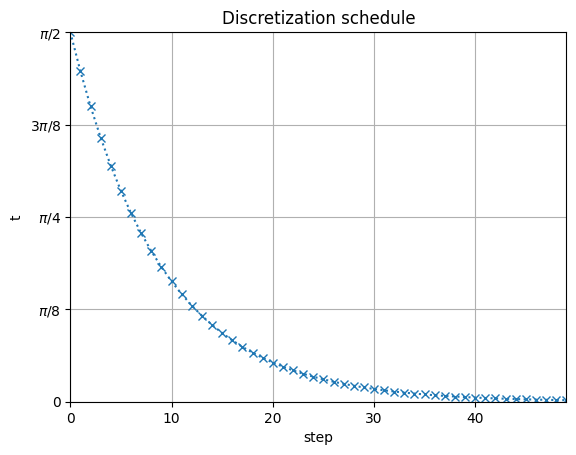

In [23]:
discretized_time = np.flip(keras.ops.convert_to_numpy(inference_network._discretize_time(steps, rho=rho)))
plt.plot(discretized_time, marker="x", linestyle="dotted")
plt.ylabel("t")
plt.xlabel("step")
plt.ylim(0.0, np.pi / 2)
plt.xlim(0, len(discretized_time) - 1)
plt.yticks(
    [0.0, np.pi / 8, np.pi / 4, 3 * np.pi / 8, np.pi / 2],
    labels=["0", r"$\pi/8$", r"$\pi/4$", r"$3\pi/8$", r"$\pi/2$"],
)
plt.grid()
_ = plt.title("Discretization schedule")

Plot the time embedding:

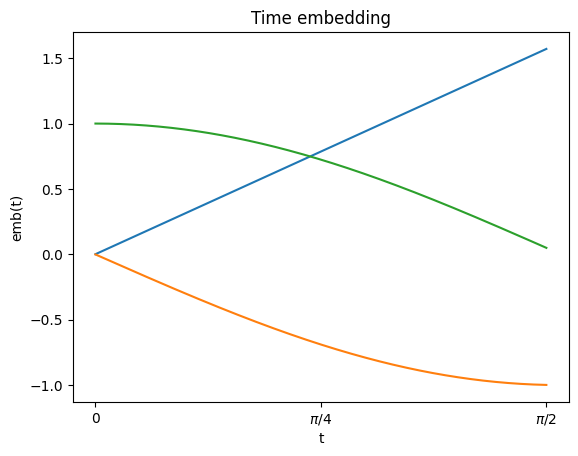

In [24]:
t = keras.ops.linspace(0.001, np.pi / 2, 500)[:, None]
emb = inference_network.time_emb(t)
plt.plot(keras.ops.convert_to_numpy(t)[:, 0], keras.ops.convert_to_numpy(emb))
plt.ylabel("emb(t)")
plt.xlabel("t")
plt.xticks([0.0, np.pi / 4, np.pi / 2], labels=["0", r"$\pi/4$", r"$\pi/2$"])
_ = plt.title("Time embedding")

Plot the learned adaptive weighting function:

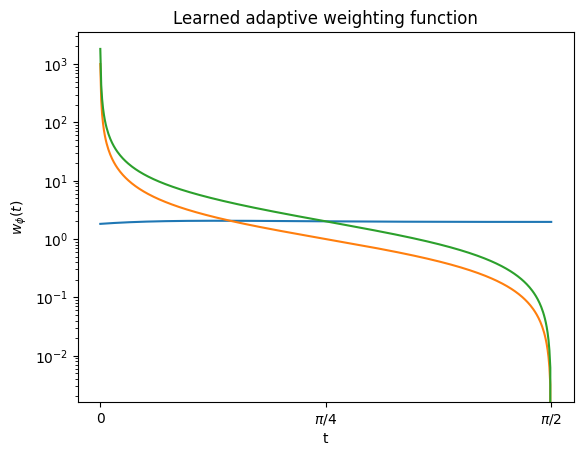

In [27]:
plt.plot(t, inference_network.weight_fn_projector(inference_network.weight_fn(t)))
plt.plot(t, 1 / (inference_network.sigma * np.tan(t)))
plt.plot(
    t,
    inference_network.weight_fn_projector(inference_network.weight_fn(t))
    / (inference_network.sigma * np.tan(t)),
)
plt.ylabel(r"$w_\phi(t)$")
plt.xlabel("t")
plt.yscale("log")
plt.xticks([0.0, np.pi / 4, np.pi / 2], labels=["0", r"$\pi/4$", r"$\pi/2$"])
_ = plt.title("Learned adaptive weighting function")